In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import apex # https://github.com/NVIDIA/apex.git
from apex.amp import amp

import os, sys, datetime
import itertools
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
gen = False
# gen = True
cuda=True
half=True
half=False
multi_gpu = True
num_workers = 16

# if not gen:
#     f = all_data['e'][2]

# time_fish = T.from_numpy(f.frame_st.mean(1).astype(np.float32)).cuda()
# u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
# p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
# u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

In [4]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ])
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [5]:
def get_frames_from_z(z, fish,half=False):
    tiff = fish.get_tif_rasl(z)
    ntime = fish.frame_et.shape[0]
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    frames = np.zeros((ntime, tiff.frame_shape[0],tiff.frame_shape[1])).astype(dtype)
    for t in range(ntime):
        frame = np.array(tiff.get_frame(t)).astype(dtype)
        frames[t] = frame
    return frames

def get_imaging_from_fish(f,n_jobs=8, half=False):
    nZ = f.num_zplanes
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    # frames_by_z = pool.map(partial(get_frames_from_z, fish=f), range(nZ))
    frames_by_z = Parallel(n_jobs=n_jobs)(delayed(get_frames_from_z)(z,fish=f) for z in range(nZ))
    imaging = np.stack(frames_by_z).swapaxes(0,1).astype(dtype)
    return imaging

def gen_imaging(nT, nZ, H, W, half=False):
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    return np.random.randint(0,3000,[nT,nZ,H,W]).astype(dtype)

In [6]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [7]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [8]:
if gen:
    imaging = gen_imaging(32,11,232,512)
else:
#     imaging = get_imaging_from_fish(f)
# imaging = resize_batch(imaging,0.5,0.5)
# np.savez('/home/ubuntu/f01555.npz',fish=imaging)
# np.savez('/home/ubuntu/f01555_small.npz',fish=imaging)
#     imaging = np.load('/home/ubuntu/f01555.npz')['fish']
    imaging = np.load('/home/ubuntu/f01555_small.npz')['fish']

In [9]:
class FishImageData(Dataset):    
    def __init__(self, imaging):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        
    def __len__(self):
        return self.data.shape[0]-1

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+1]
    
class FishDiffData(Dataset):    
    def __init__(self, imaging):
        X = imaging - imaging.mean(0)
        self.X = T.from_numpy(X)
        self.Y = T.from_numpy(np.diff(X, axis=0))
        
    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class FishMultData(Dataset):    
    def __init__(self, imaging, prev_frames=2, next_frames=1):
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        
    def __len__(self):
        return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        idx = i + self.prev_frames - 1 # avoid wraparound
        X = []
        Y = []
        for i in reversed(range(self.prev_frames)):
            X.append(self.data[idx-i])
        for i in range(1,self.next_frames+1):
            Y.append(self.data[idx+i])
        X = T.stack(X,1)
        Y = T.stack(Y,1)
        return X, Y

# data = FishImageData(imaging)
# data = FishDiffData(imaging)
prev_frames = 5
next_frames = 5
data = FishMultData(imaging,prev_frames,next_frames)

nZ, _, H, W = data[0][0].shape

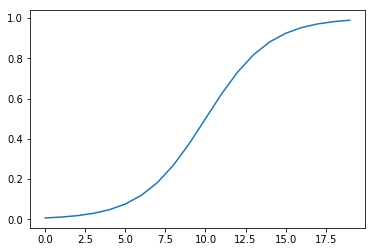

In [10]:
def sigmoid_schedule(t,k=5):
    t0 = t/2
    k = k/t0
    t = np.arange(t)
    return (1/(1+np.exp(-k*(t-t0)))).astype(np.float32)

plt.plot(sigmoid_schedule(20,5))

In [11]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo



def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, prev_frames=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(prev_frames, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # for full-size images
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(8, stride=1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 232 x 512
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
#         print(x.shape)
        # 58 x 128

        x = self.layer1(x)
#         print(x.shape)
        # 29 x 64
        x = self.layer2(x)
#         print(x.shape)
        # 15 x 32
        x = self.layer3(x)
#         print(x.shape)
        # 8 x 16
        x = self.layer4(x)
        # 4 x 8
        x = x.view(x.shape[0],-1).mean(1)
        # 1 x 1
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        return x[:,None]

In [12]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['SAME', 'VALID']
    if padding_type == 'SAME':
        return tuple((k - 1) // 2 for k in kernel_size)
    return tuple(0 for _ in kernel_size)


class Vol2D(nn.Module):
    "Use same 2D operations mapped over each z slice"
    def __init__(self, tensor=T.cuda.FloatTensor):
        super(Vol2D, self).__init__()
        self.tensor = tensor
        
    def vol_PixelShuffle(self, x):
        # Helper for subpixel convolution
        first = self.pixel_shuffle(x[:,0])
        # b x z x H x W
        ret = self.tensor(x.shape[0],x.shape[1],first.shape[2], first.shape[3])
        for z in range(x.shape[1]):
            ret[:,z] = self.pixel_shuffle(x[:,z])[:,0]
        return ret
        
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_MaxPool2d(self, x, kernel_size):
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_BatchNorm2d(self, x, bn):
        activations = self.tensor(x.shape)
        for z in range(x.shape[1]):
            activations[:,z] = bn(x[:,z].contiguous())
        return activations
                
    def vol_conv2d(self, x, weight, pad):
        # batch x Z x C x H x W
        activations = self.tensor(x.shape[0],x.shape[1],weight.shape[0],x.shape[3],x.shape[4])
        for z in range(x.shape[1]):
            activations[:,z] = F.conv2d(x[:,z], weight, padding=pad)
        return activations
    
    def crop(self, x):
        cropH = (x.shape[2] - self.H)/2
        cropW = (x.shape[3] - self.W)/2
        if cropH>0:
            x = x[:,:,int(np.floor(cropH)):-int(np.ceil(cropH))]
        if cropW>0:
            x = x[:,:,:,int(np.floor(cropW)):-int(np.ceil(cropW))]
        return x

class SuperResBlock(Vol2D):
    """Upsample Volume using subpixel convolution.
    
    Reference: https://arxiv.org/pdf/1609.05158.pdf"""
    def __init__(self, upscale_factor, tensor):
        super(SuperResBlock, self).__init__(tensor=T.cuda.FloatTensor)
        self.tensor = tensor
        self.activation = nn.ReLU()
        self.dconv1 = nn.Parameter(self.tensor(64,1,5,5))
        self.dpad1 = (2,2)
        self.dbn1 = nn.BatchNorm2d(64)
        self.dconv2 = nn.Parameter(self.tensor(64,64,3,3))
        self.dpad2 = (1,1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Parameter(self.tensor(32,64,3,3))
        self.dpad3 = (1,1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dconv4 = nn.Parameter(self.tensor(upscale_factor**2,32,3,3))
        self.dpad4 = (1,1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self.initialize_weights()

    def forward(self, x):        
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv1, self.dpad1), self.dbn1))
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv2, self.dpad2), self.dbn2))
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv3, self.dpad3), self.dbn3))
        x = self.vol_conv2d(x, self.dconv4, self.dpad4)
        x = self.vol_PixelShuffle(x)
        # add back single channel
        x = x[:,:,None]
        return x
    
    def initialize_weights(self):
        if self.tensor==T.cuda.FloatTensor:
            nn.init.orthogonal_(self.dconv1, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv2, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv3, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv4)
        else:
            for m in [self.dconv1, self.dconv2, self.dconv3, self.dconv4]:
                nn.init.kaiming_normal_(m, mode='fan_out', nonlinearity='relu')
        for bn in [self.dbn1,self.dbn2,self.dbn3]:
            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)
    

In [13]:
class tofp16(nn.Module):
    """
    Model wrapper that implements::
        def forward(self, input):
            return input.half()
    """

    def __init__(self):
        super(tofp16, self).__init__()

    def forward(self, input):
        return input.cuda().half()


def BN_convert_float(module):
    '''
    Designed to work with network_to_half.
    BatchNorm layers need parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        BN_convert_float(child)
    return module


def network_to_half(network):
    """
    Convert model to half precision in a batchnorm-safe way.
    """
    return nn.Sequential(tofp16(), BN_convert_float(network.half()))

In [14]:
class Conv(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1,
                 tensor=T.cuda.FloatTensor):
        super(Conv, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 8
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 1
        
        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        
        # Prediction
        self.pred1 = nn.Linear(nEmbedding, nEmbedding)
        self.pred_bn1 = nn.BatchNorm1d(nEmbedding)
        self.pred2 = nn.Linear(nEmbedding, nEmbedding)
        
        # Decoding
        self.activation = nn.Tanh()
        self.decoding = nn.Linear(nEmbedding,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResBlock(2,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResBlock(2,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResBlock(2,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResBlock(2,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResBlock(2,tensor)
        # 11 x 256 x 512
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)
    
    def sample_embedding(self, mu, logvar):
        if self.training:
            # during training so far, had this implementation which lowers logvar (until Jul 7, 2018)
#             std = torch.exp(0.1*logvar)
#             dist = T.distributions.normal.Normal(T.zeros_like(std),T.ones_like(std))
#             std_z = dist.sample()
#             return mu + std*std_z
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        for z in range(x.shape[1]):
            out[:,z] = self.resnet(x[:,z])
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar
     
    def predict(self, x):
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x
        
    def decode(self, x):
        # b x 20
        x = self.activation(self.decoding(x))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x

    def forward(self, x):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_pred = self.predict(encoded)
        pred = self.decode(encoded_pred)
        return pred, mean, logvar

    
def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,data,nepochs=10, lr=1e-3, half=False, cuda=True):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)
        
    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            # add 1 channel
            if cuda:
                # half will alrea
                X = X.cuda()
                Y = Y.cuda()
            Y_pred, mean, logvar = model(X)
            if half:
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            if np.random.rand()>0.5:
                mse_Y = F.mse_loss(Y_pred, Y[:,:,4], size_average=False)
            else:
                mse_Y = F.mse_loss(Y_pred, Y[:,:,3], size_average=False)
            loss = mse_Y + kl_schedule[e] * kld
#             if e==0:
#                 print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}".format(float(mse_X),float(mse_Y),float(kld)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_Y_loss += float(mse_Y)

        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}".format(
            cum_loss/len(data), cum_X_loss/len(data), cum_Y_loss/len(data)))        

nEmbedding = 10
batch_size = 64
tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

conv_model = Conv(nZ,H,W,nEmbedding,prev_frames,tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 869792


In [15]:
train(conv_model,data,100,lr=1e-3, half=half, cuda=cuda)
# 1.91E+02

epoch 0: 


avg_loss: 8.481449E+08, X_loss: 0.000000E+00, Y_loss: 8.481449E+08
epoch 1: 


avg_loss: 8.147758E+08, X_loss: 0.000000E+00, Y_loss: 8.147758E+08
epoch 2: 


avg_loss: 7.767910E+08, X_loss: 0.000000E+00, Y_loss: 7.767910E+08
epoch 3: 


avg_loss: 7.605135E+08, X_loss: 0.000000E+00, Y_loss: 7.605135E+08
epoch 4: 


avg_loss: 7.487947E+08, X_loss: 0.000000E+00, Y_loss: 7.487947E+08
epoch 5: 


avg_loss: 7.379934E+08, X_loss: 0.000000E+00, Y_loss: 7.379934E+08
epoch 6: 


avg_loss: 7.290126E+08, X_loss: 0.000000E+00, Y_loss: 7.290126E+08
epoch 7: 


avg_loss: 7.198563E+08, X_loss: 0.000000E+00, Y_loss: 7.198563E+08
epoch 8: 


avg_loss: 7.124278E+08, X_loss: 0.000000E+00, Y_loss: 7.124278E+08
epoch 9: 


avg_loss: 7.050947E+08, X_loss: 0.000000E+00, Y_loss: 7.050947E+08
epoch 10: 


avg_loss: 6.978727E+08, X_loss: 0.000000E+00, Y_loss: 6.978727E+08
epoch 11: 


avg_loss: 6.932407E+08, X_loss: 0.000000E+00, Y_loss: 6.932407E+08
epoch 12: 


avg_loss: 6.869546E+08, X_loss: 0.000000E+00, Y_loss: 6.869546E+08
epoch 13: 


avg_loss: 6.808858E+08, X_loss: 0.000000E+00, Y_loss: 6.808858E+08
epoch 14: 


avg_loss: 6.762786E+08, X_loss: 0.000000E+00, Y_loss: 6.762786E+08
epoch 15: 


avg_loss: 6.725535E+08, X_loss: 0.000000E+00, Y_loss: 6.725535E+08
epoch 16: 


avg_loss: 6.690133E+08, X_loss: 0.000000E+00, Y_loss: 6.690133E+08
epoch 17: 


avg_loss: 6.648450E+08, X_loss: 0.000000E+00, Y_loss: 6.648450E+08
epoch 18: 


avg_loss: 6.617403E+08, X_loss: 0.000000E+00, Y_loss: 6.617403E+08
epoch 19: 


avg_loss: 6.576292E+08, X_loss: 0.000000E+00, Y_loss: 6.576292E+08
epoch 20: 


avg_loss: 6.550583E+08, X_loss: 0.000000E+00, Y_loss: 6.550583E+08
epoch 21: 


avg_loss: 6.524091E+08, X_loss: 0.000000E+00, Y_loss: 6.524091E+08
epoch 22: 


avg_loss: 6.498593E+08, X_loss: 0.000000E+00, Y_loss: 6.498593E+08
epoch 23: 


avg_loss: 6.473380E+08, X_loss: 0.000000E+00, Y_loss: 6.473380E+08
epoch 24: 


avg_loss: 6.476573E+08, X_loss: 0.000000E+00, Y_loss: 6.476573E+08
epoch 25: 


avg_loss: 6.447552E+08, X_loss: 0.000000E+00, Y_loss: 6.447552E+08
epoch 26: 


avg_loss: 6.430417E+08, X_loss: 0.000000E+00, Y_loss: 6.430417E+08
epoch 27: 


avg_loss: 6.399724E+08, X_loss: 0.000000E+00, Y_loss: 6.399724E+08
epoch 28: 


avg_loss: 6.382927E+08, X_loss: 0.000000E+00, Y_loss: 6.382927E+08
epoch 29: 


avg_loss: 6.369359E+08, X_loss: 0.000000E+00, Y_loss: 6.369359E+08
epoch 30: 


avg_loss: 6.357422E+08, X_loss: 0.000000E+00, Y_loss: 6.357422E+08
epoch 31: 


avg_loss: 6.343602E+08, X_loss: 0.000000E+00, Y_loss: 6.343602E+08
epoch 32: 


avg_loss: 6.316436E+08, X_loss: 0.000000E+00, Y_loss: 6.316436E+08
epoch 33: 


avg_loss: 6.315003E+08, X_loss: 0.000000E+00, Y_loss: 6.315003E+08
epoch 34: 


avg_loss: 6.306033E+08, X_loss: 0.000000E+00, Y_loss: 6.306033E+08
epoch 35: 


avg_loss: 6.306381E+08, X_loss: 0.000000E+00, Y_loss: 6.306381E+08
epoch 36: 


avg_loss: 6.279221E+08, X_loss: 0.000000E+00, Y_loss: 6.279221E+08
epoch 37: 


avg_loss: 6.248879E+08, X_loss: 0.000000E+00, Y_loss: 6.248879E+08
epoch 38: 


avg_loss: 6.247906E+08, X_loss: 0.000000E+00, Y_loss: 6.247906E+08
epoch 39: 


avg_loss: 6.267890E+08, X_loss: 0.000000E+00, Y_loss: 6.267890E+08
epoch 40: 


avg_loss: 6.257131E+08, X_loss: 0.000000E+00, Y_loss: 6.257131E+08
epoch 41: 


avg_loss: 6.216998E+08, X_loss: 0.000000E+00, Y_loss: 6.216998E+08
epoch 42: 


avg_loss: 6.218656E+08, X_loss: 0.000000E+00, Y_loss: 6.218656E+08
epoch 43: 


avg_loss: 6.214630E+08, X_loss: 0.000000E+00, Y_loss: 6.214630E+08
epoch 44: 


avg_loss: 6.198178E+08, X_loss: 0.000000E+00, Y_loss: 6.198178E+08
epoch 45: 


avg_loss: 6.183662E+08, X_loss: 0.000000E+00, Y_loss: 6.183662E+08
epoch 46: 


avg_loss: 6.183292E+08, X_loss: 0.000000E+00, Y_loss: 6.183292E+08
epoch 47: 


avg_loss: 6.194152E+08, X_loss: 0.000000E+00, Y_loss: 6.194152E+08
epoch 48: 


avg_loss: 6.158118E+08, X_loss: 0.000000E+00, Y_loss: 6.158118E+08
epoch 49: 


avg_loss: 6.154131E+08, X_loss: 0.000000E+00, Y_loss: 6.154131E+08
epoch 50: 


avg_loss: 6.142891E+08, X_loss: 0.000000E+00, Y_loss: 6.142890E+08
epoch 51: 


avg_loss: 6.184509E+08, X_loss: 0.000000E+00, Y_loss: 6.184508E+08
epoch 52: 


avg_loss: 6.142193E+08, X_loss: 0.000000E+00, Y_loss: 6.142193E+08
epoch 53: 


avg_loss: 6.135240E+08, X_loss: 0.000000E+00, Y_loss: 6.135240E+08
epoch 54: 


avg_loss: 6.115660E+08, X_loss: 0.000000E+00, Y_loss: 6.115659E+08
epoch 55: 


avg_loss: 6.131987E+08, X_loss: 0.000000E+00, Y_loss: 6.131986E+08
epoch 56: 


avg_loss: 6.123070E+08, X_loss: 0.000000E+00, Y_loss: 6.123070E+08
epoch 57: 


avg_loss: 6.094337E+08, X_loss: 0.000000E+00, Y_loss: 6.094336E+08
epoch 58: 


avg_loss: 6.104768E+08, X_loss: 0.000000E+00, Y_loss: 6.104768E+08
epoch 59: 


avg_loss: 6.100914E+08, X_loss: 0.000000E+00, Y_loss: 6.100914E+08
epoch 60: 


avg_loss: 6.083787E+08, X_loss: 0.000000E+00, Y_loss: 6.083786E+08
epoch 61: 


avg_loss: 6.095875E+08, X_loss: 0.000000E+00, Y_loss: 6.095874E+08
epoch 62: 


avg_loss: 6.113159E+08, X_loss: 0.000000E+00, Y_loss: 6.113158E+08
epoch 63: 


avg_loss: 6.076590E+08, X_loss: 0.000000E+00, Y_loss: 6.076590E+08
epoch 64: 


avg_loss: 6.067587E+08, X_loss: 0.000000E+00, Y_loss: 6.067587E+08
epoch 65: 


avg_loss: 6.069471E+08, X_loss: 0.000000E+00, Y_loss: 6.069470E+08
epoch 66: 


avg_loss: 6.079433E+08, X_loss: 0.000000E+00, Y_loss: 6.079433E+08
epoch 67: 


avg_loss: 6.058527E+08, X_loss: 0.000000E+00, Y_loss: 6.058526E+08
epoch 68: 


avg_loss: 6.064328E+08, X_loss: 0.000000E+00, Y_loss: 6.064327E+08
epoch 69: 


avg_loss: 6.057564E+08, X_loss: 0.000000E+00, Y_loss: 6.057563E+08
epoch 70: 


avg_loss: 6.048300E+08, X_loss: 0.000000E+00, Y_loss: 6.048300E+08
epoch 71: 


avg_loss: 6.041514E+08, X_loss: 0.000000E+00, Y_loss: 6.041513E+08
epoch 72: 


avg_loss: 6.049086E+08, X_loss: 0.000000E+00, Y_loss: 6.049086E+08
epoch 73: 


avg_loss: 6.065041E+08, X_loss: 0.000000E+00, Y_loss: 6.065040E+08
epoch 74: 


avg_loss: 6.042672E+08, X_loss: 0.000000E+00, Y_loss: 6.042671E+08
epoch 75: 


avg_loss: 6.016938E+08, X_loss: 0.000000E+00, Y_loss: 6.016937E+08
epoch 76: 


avg_loss: 6.028582E+08, X_loss: 0.000000E+00, Y_loss: 6.028581E+08
epoch 77: 


avg_loss: 6.016901E+08, X_loss: 0.000000E+00, Y_loss: 6.016900E+08
epoch 78: 


avg_loss: 6.039587E+08, X_loss: 0.000000E+00, Y_loss: 6.039587E+08
epoch 79: 


avg_loss: 6.007700E+08, X_loss: 0.000000E+00, Y_loss: 6.007699E+08
epoch 80: 


avg_loss: 6.010069E+08, X_loss: 0.000000E+00, Y_loss: 6.010069E+08
epoch 81: 


avg_loss: 5.996932E+08, X_loss: 0.000000E+00, Y_loss: 5.996931E+08
epoch 82: 


avg_loss: 6.015858E+08, X_loss: 0.000000E+00, Y_loss: 6.015858E+08
epoch 83: 


avg_loss: 6.001399E+08, X_loss: 0.000000E+00, Y_loss: 6.001398E+08
epoch 84: 


avg_loss: 5.997602E+08, X_loss: 0.000000E+00, Y_loss: 5.997601E+08
epoch 85: 


avg_loss: 6.004815E+08, X_loss: 0.000000E+00, Y_loss: 6.004815E+08
epoch 86: 


avg_loss: 5.994848E+08, X_loss: 0.000000E+00, Y_loss: 5.994847E+08
epoch 87: 


avg_loss: 5.979512E+08, X_loss: 0.000000E+00, Y_loss: 5.979511E+08
epoch 88: 


avg_loss: 5.974625E+08, X_loss: 0.000000E+00, Y_loss: 5.974625E+08
epoch 89: 


avg_loss: 5.987316E+08, X_loss: 0.000000E+00, Y_loss: 5.987315E+08
epoch 90: 


avg_loss: 5.979783E+08, X_loss: 0.000000E+00, Y_loss: 5.979783E+08
epoch 91: 


avg_loss: 5.977258E+08, X_loss: 0.000000E+00, Y_loss: 5.977257E+08
epoch 92: 


avg_loss: 5.975746E+08, X_loss: 0.000000E+00, Y_loss: 5.975746E+08
epoch 93: 


avg_loss: 5.965493E+08, X_loss: 0.000000E+00, Y_loss: 5.965492E+08
epoch 94: 


avg_loss: 5.956828E+08, X_loss: 0.000000E+00, Y_loss: 5.956827E+08
epoch 95: 


avg_loss: 5.954272E+08, X_loss: 0.000000E+00, Y_loss: 5.954272E+08
epoch 96: 


avg_loss: 5.961267E+08, X_loss: 0.000000E+00, Y_loss: 5.961266E+08
epoch 97: 


avg_loss: 5.959602E+08, X_loss: 0.000000E+00, Y_loss: 5.959601E+08
epoch 98: 


avg_loss: 5.945177E+08, X_loss: 0.000000E+00, Y_loss: 5.945177E+08
epoch 99: 


avg_loss: 5.946564E+08, X_loss: 0.000000E+00, Y_loss: 5.946563E+08


In [16]:
model_name = "180713_small_X5_predY+5_MSE(Y):5.94E+08"

In [17]:
T.save(conv_model.state_dict(),model_name+".pt")

conv_model.load_state_dict(T.load(model_name+".pt"))

In [18]:
def volume_mse(X, Y):
    with T.no_grad():
        loss = F.mse_loss(X,Y,reduce=False).reshape(X.shape[0],-1).sum(1)
    return loss

In [19]:
def sampleMSE(model,data, batch_size=256):
    prev_frames = data.prev_frames
    next_frames = data.next_frames
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    xlabels = ['X_t'] + ['X_t-{}'.format(i) for i in range(1,prev_frames)]
    ylabels = ['Y_t+{}'.format(i) for i in range(1,next_frames+1)] + ['Y_pred']
    labels = xlabels+ylabels
    mses = {"MSE({},{})".format(x,y): [] for x,y in itertools.product(labels, labels)}
    size = len(data)
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            Y_pred, _, _ = model(X)
            xs = [X[:,:,i] for i in reversed(range(prev_frames))]
            ys = [Y[:,:,i] for i in range(next_frames)] + [Y_pred]
            dat = xs+ys
            iter = itertools.product(zip(labels,dat), zip(labels,dat))
            for (xlabel, x), (ylabel, y) in iter:
                mse = volume_mse(x,y)
                mses["MSE({},{})".format(xlabel,ylabel)].append(mse)
    mses = {k: T.cat(v).cpu().numpy() for k,v in mses.items()}
    return mses

mses = sampleMSE(conv_model, data)

In [20]:
idx = np.argsort(mses['MSE(X_t,Y_t+1)'])[-250:]

Text(0.5,1,'Distribution of MSE for different timesteps')

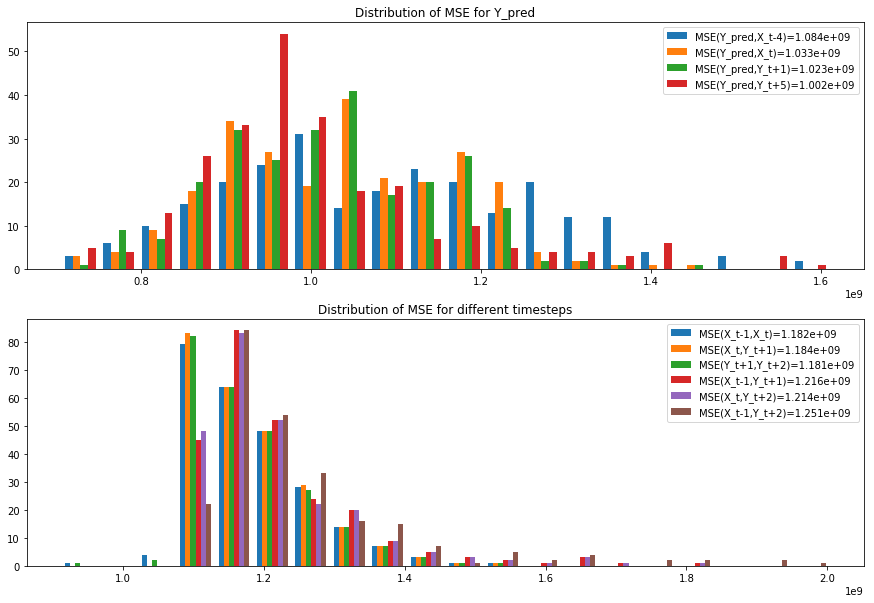

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
labels = ['MSE(Y_pred,X_t-4)', 'MSE(Y_pred,X_t)', 'MSE(Y_pred,Y_t+1)', 'MSE(Y_pred,Y_t+5)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for Y_pred")

plt.subplot(2,1,2)
labels = ['MSE(X_t-1,X_t)', 'MSE(X_t,Y_t+1)', 'MSE(Y_t+1,Y_t+2)',
          'MSE(X_t-1,Y_t+1)', 'MSE(X_t,Y_t+2)',
          'MSE(X_t-1,Y_t+2)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for different timesteps")

In [29]:
for k,v in mses.items():
    if k[:11]=="MSE(Y_pred,":
        print("{}: {:.4g}".format(k,v.mean()))

MSE(Y_pred,X_t-1): 7.085e+08
MSE(Y_pred,X_t-2): 7.108e+08
MSE(Y_pred,X_t-3): 7.13e+08
MSE(Y_pred,Y_pred): 0
MSE(Y_pred,X_t): 7.065e+08
MSE(Y_pred,X_t-4): 7.153e+08
MSE(Y_pred,Y_t+5): 7.015e+08
MSE(Y_pred,Y_t+4): 7.014e+08
MSE(Y_pred,Y_t+3): 7.021e+08
MSE(Y_pred,Y_t+2): 7.032e+08
MSE(Y_pred,Y_t+1): 7.047e+08


In [34]:
scipy.stats.mannwhitneyu(mses['MSE(Y_pred,X_t)'][idx],
                         mses['MSE(Y_pred,Y_t+5)'][idx],
                        alternative='greater')

MannwhitneyuResult(statistic=36592.0, pvalue=0.000472007246778939)

In [32]:
scipy.stats.mannwhitneyu(mses['MSE(Y_pred,X_t-1)'][idx],
                         mses['MSE(Y_pred,Y_t+3)'][idx],
                        alternative='greater')

MannwhitneyuResult(statistic=35817.0, pvalue=0.002349822414728356)

In [39]:
scipy.stats.mannwhitneyu(mses['MSE(Y_pred,X_t)'][idx],
                         mses['MSE(Y_pred,Y_t+2)'][idx],
                        alternative='greater')

MannwhitneyuResult(statistic=33019.0, pvalue=0.13680101376510978)

In [31]:
scipy.stats.mannwhitneyu(mses['MSE(Y_pred,X_t-1)'][idx],
                         mses['MSE(Y_pred,Y_t+2)'][idx],
                        alternative='greater')

MannwhitneyuResult(statistic=33545.0, pvalue=0.07774127787577323)

In [28]:
def plot_model_vs_real(model,data):
    plt.figure(figsize=(30,15))

    with T.no_grad():
        for i in range(4):
            time = np.random.randint(len(data))
            z = np.random.randint(nZ)
            X, Y = data[time]
            x = X[None].cuda()
            y = Y[None].cuda()
            X_pred, Y_pred, _, _ = model(x)
            mse_X = float(F.mse_loss(X_pred,x[:,:,0]).cpu())
            mse_X_pred_to_Y = float(F.mse_loss(X_pred,y[:,:,0]).cpu())
            mse_Y_pred_to_X = float(F.mse_loss(Y_pred,x[:,:,-1]).cpu())
            mse_Y = float(F.mse_loss(Y_pred,y[:,:,-1]).cpu())
            prev_loss = float(F.mse_loss(x[:,:,0],y[:,:,-1]).cpu())
#             x_zero_loss = float(F.mse_loss(x,T.zeros_like(x)).cpu())
#             y_zero_loss = float(F.mse_loss(y,T.zeros_like(y)).cpu())
            mymin = min(float(y[0,z].min()[0]),float(x[0,z].min()[0]),float(X_pred[0,z].min()[0]))
            mymax = max(float(y[0,z].max()[0]),float(x[0,z].max()[0]),float(X_pred[0,z].max()[0]))
            
            plt.subplot(4,4,i*4+1)
            plt.imshow(X[z,-1].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+2)
            plt.imshow(Y[z,0].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time+1) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+3)
            plt.imshow(X_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (X_pred,X)={:.0f}, (X_pred,Y)={:.0f}".format(mse_X,mse_X_pred_to_Y))
            
            plt.subplot(4,4,i*4+4)
            plt.imshow(Y_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (Y_pred,Y)={:.0f}, (Y_pred,X)={:.0f}".format(mse_Y,mse_Y_pred_to_X))

plot_model_vs_real(conv_model,data)

NameError: global name 'X_pred' is not defined

<Figure size 2160x1080 with 0 Axes>

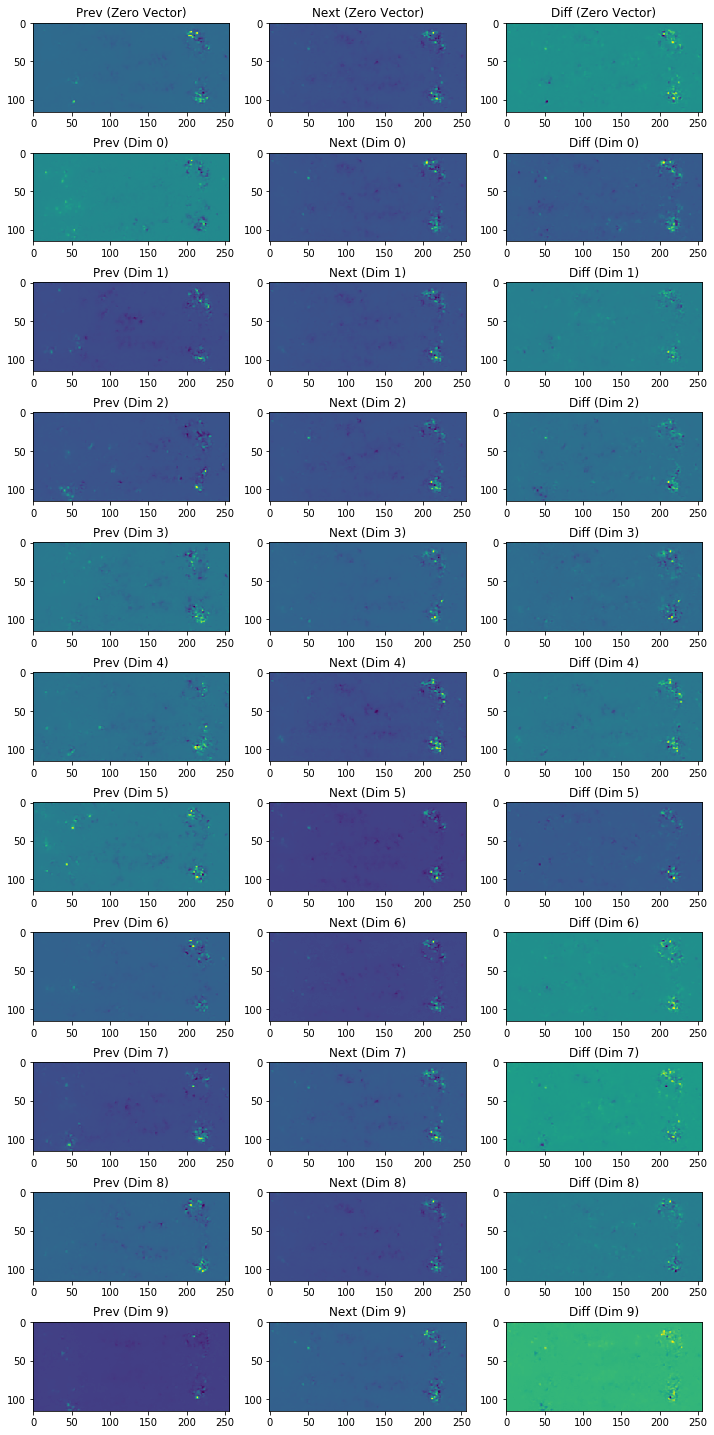

In [27]:
def get_gradient_from_embedding(model,frame,embedding,niters=20, lr=1e-3):
    model.eval()
    frame = frame.cuda()
    frame.requires_grad = True
    embedding_pred, _ = model.encode(frame)
    print(embedding_pred.shape)
    embedding_pred.backward(gradient=embedding)
    return frame.grad[0]

def get_input_from_embedding(model,frame,embedding,niters=75, lr=1e-1, rand=False):
    "Take an embedding vector, and use backprop to find the volume"
    if rand:
        prev_img = T.rand_like(frame[None], requires_grad=True).cuda()
    else:
        prev_img = frame[None].cuda()
        prev_img.requires_grad = True
    optimizer = T.optim.Adam([prev_img],lr=lr)
    model.eval()
    for i in range(niters):
        embedding_pred, _ = model.encode(prev_img)
        loss = F.mse_loss(embedding_pred,embedding[None]) #+ 1e-7*T.norm(prev_img,1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print("iter {} loss: ".format(i), float(loss))
    model.train()
    return prev_img[0].detach().cpu().numpy()

def interpret(model,prev_vol, next_vol, nEmbedding, prev_func):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,20))
    
    embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
    with T.no_grad():
        prev_img = model.decode(embedding)[0]
        next_img = model.decode(model.predict(embedding))[0]
    plt.subplot(1+nEmbedding,3,1)
    plt.imshow(prev_img[6])
    plt.title("Prev (Zero Vector)")
    plt.subplot(1+nEmbedding,3,2)
    plt.imshow(next_img[6])
    plt.title("Next (Zero Vector)")
    plt.subplot(1+nEmbedding,3,3)
    plt.imshow(next_img[6] - prev_img[6])
    plt.title("Diff (Zero Vector)")
    for i in range(nEmbedding):
        embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
        with T.no_grad():
            prev_img = model.decode(embedding)[0]
            next_img = model.decode(model.predict(embedding))[0]
        plt.subplot(1+nEmbedding,3,i*3+4)
        plt.imshow(prev_img[6])
        plt.title("Prev (Dim {})".format(i))
        plt.subplot(1+nEmbedding,3,i*3+5)
        plt.imshow(next_img[6])
        plt.title("Next (Dim {})".format(i))
        plt.subplot(1+nEmbedding,3,i*3+6)
        plt.imshow(next_img[6]-prev_img[6])
        plt.title("Diff (Dim {})".format(i))
    plt.tight_layout()

x, y = data[1000]
interpret(conv_model,x,y,10,get_gradient_from_embedding)

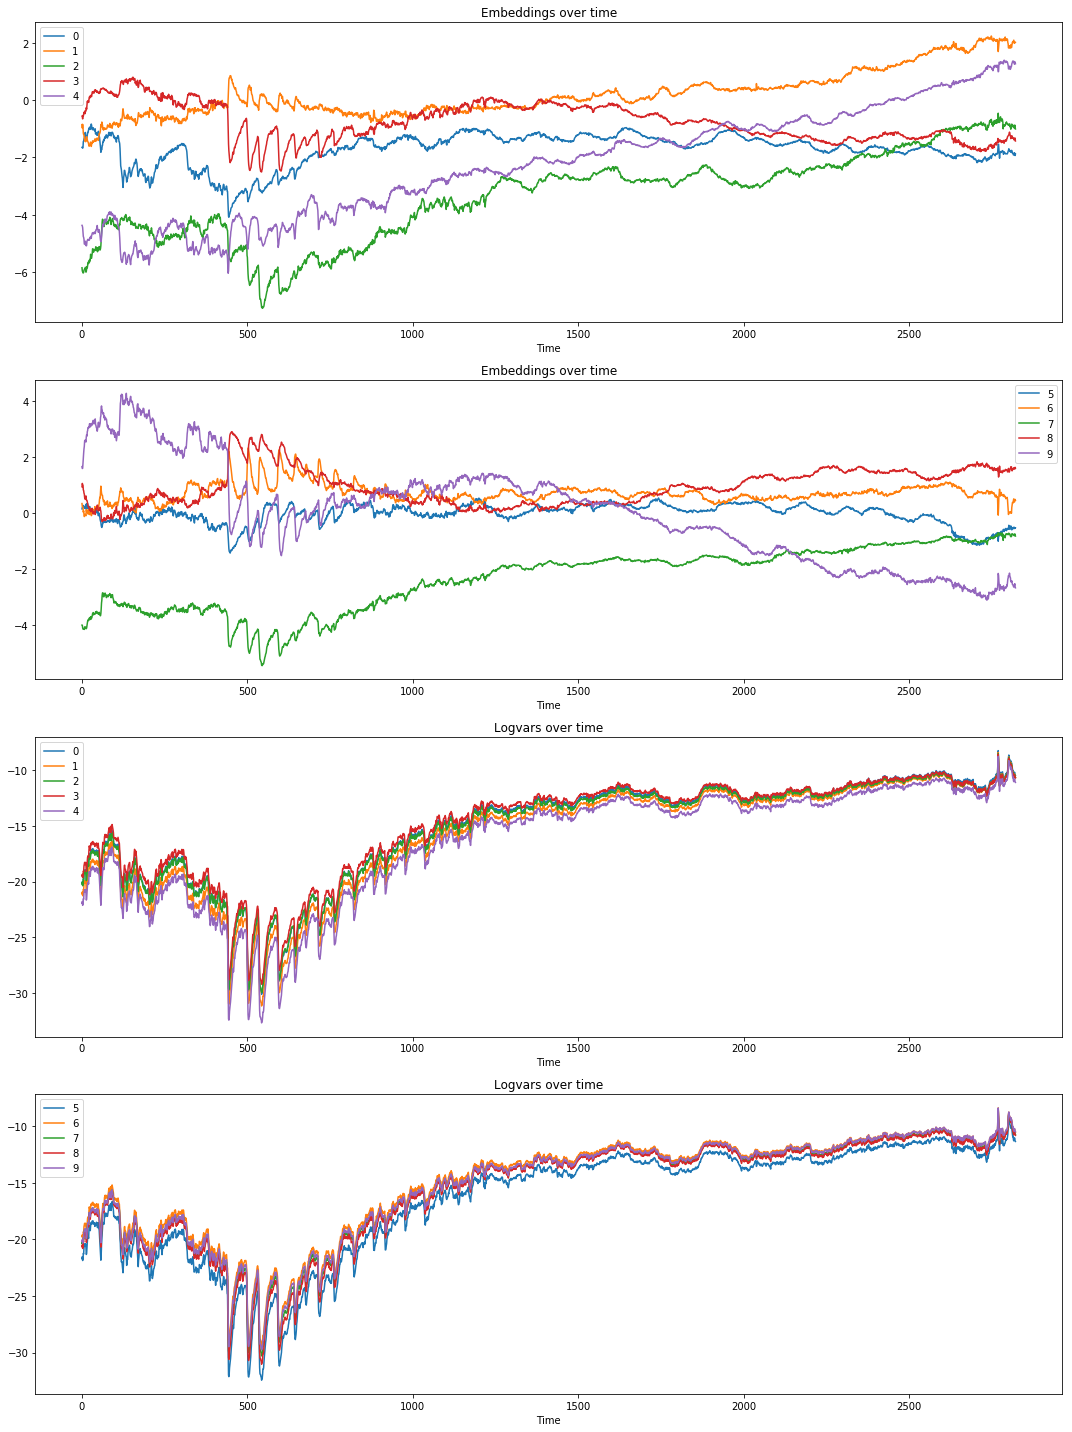

In [28]:
def plot_embedding_over_time(model,data, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embeddings = []
    logvars = []
    model.eval()
    for batch_data in dataloader:
        X, _ = batch_data
        with T.no_grad():
            embedding, logvar = model.encode(X.cuda())
        embeddings.append(embedding.cpu().numpy())
        logvars.append(logvar.cpu().numpy())
    model.train()
    embeddings = np.vstack(embeddings)
    logvars = np.vstack(logvars)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    
    plt.figure(figsize=(15,20))
    plt.subplot(4,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.subplot(4,1,3)
    plt.plot(logvars[:,0:half])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,4)
    plt.plot(logvars[:,half:])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.tight_layout()
    return embeddings
embeddings = plot_embedding_over_time(conv_model,data)

In [31]:
import skvideo.io
def makePredVideo(model, data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(model_name + ".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    for batch_data in dataloader:
        X, Y = batch_data
        with T.no_grad():
            _, vol_preds, _, _= model(X.cuda())
        for actual,pred in zip(Y,vol_preds):
            # 7th z layer
            f = pred[6]
            H = f.shape[0]
            frame = np.zeros([H*2,f.shape[1]])
            frame[:H] = actual[6,1]
            frame[H:] = pred[6]
            writer.writeFrame(frame)
            
    writer.close()
    return frame, actual[6], pred[6]
frame, actual, pred = makePredVideo(conv_model,data)

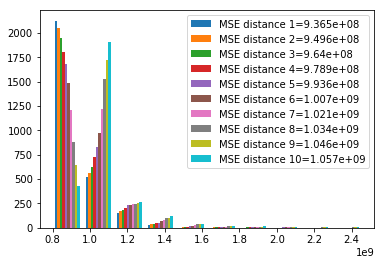

In [94]:
class FishDistanceData(Dataset):
    def __init__(self, imaging, distance):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.distance=distance
        
    def __len__(self):
        return self.data.shape[0]-self.distance

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+self.distance]

def MSEbyDist(imaging, maxdist=10, batch_size=256):
    mse = []
    
    with T.no_grad():
        for d in range(1,maxdist+1):
            data = FishDistanceData(imaging,d)
            dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            mse.append([])
            for batch_data in tqdm(dataloader):
                X, Y = batch_data
                X = X.cuda()
                Y = Y.cuda()
                mse[d-1].append(volume_mse(X, Y).cpu())

    mse = [T.cat(m).numpy() for m in mse]
    return mse

mse = MSEbyDist(imaging,10)

plt.hist(mse)
plt.legend(["MSE distance {}={:.4g}".format(d+1,m.mean()) for d, m in enumerate(mse)])

In [110]:
scipy.stats.mannwhitneyu(mse[0], mse[1], alternative='two-sided')

MannwhitneyuResult(statistic=3536209.5, pvalue=1.509944087245247e-13)